In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
#1. Reading Data and Initial Preparation
df = pd.read_csv("housing.csv")

#Creating a Categorical Column for median_income
df["class_income"] = pd.cut(
    df["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
)

#Splitting the Data into Train and Test Sets
train, test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["class_income"],
    random_state=1
)

#Dropping the Auxiliary Column class_income
train = train.drop("class_income", axis=1)
test = test.drop("class_income", axis=1)

#Separating Features and Target
train_feature = train.drop("median_house_value", axis=1)
train_target = train["median_house_value"]

test_feature = test.drop("median_house_value", axis=1)
test_target = test["median_house_value"]





array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

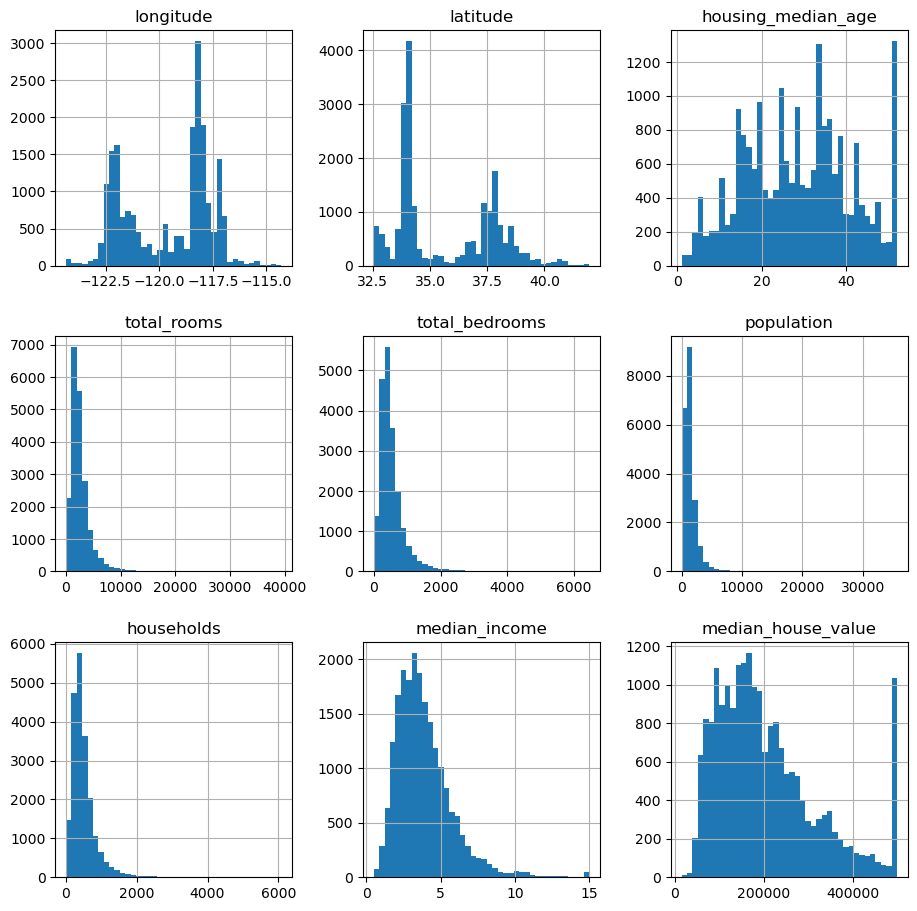

In [11]:
df.hist(bins= 40,figsize=(11,11))

In [3]:
#2. Creating New Features (Feature Engineering)
for df_ in [train_feature, test_feature]:
    df_["rooms_per_household"] = df_["total_rooms"] / df_["households"]
    df_["bedrooms_per_room"] = df_["total_bedrooms"] / df_["total_rooms"]
    df_["population_per_household"] = df_["population"] / df_["households"]


In [4]:
# 3. Defining Pipelines

#For Heavy-Tailed Features (e.g., Population and Income)
heavy_tail_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])

#For Regular Numeric Features
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

#For Categorical Features
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#RBF Transformation for the house_age Column
median_age_rbf = FunctionTransformer(
    lambda x: rbf_kernel(x, [[35.0]], gamma=0.1),
    feature_names_out="one-to-one"
)

In [5]:
#4. Selecting Columns and Building a ColumnTransformer
numerical_cols = list(train_feature.columns)
numerical_cols.remove("ocean_proximity")
categorical_cols = ["ocean_proximity"]

all_transform = ColumnTransformer([
    ("heavy", heavy_tail_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("rbf", median_age_rbf, ["housing_median_age"]),
    ("cat", categorical_pipeline, categorical_cols),
    ("num", numerical_pipeline, ["rooms_per_household", "bedrooms_per_room", "population_per_household"])
])

In [6]:
#5. Applying Transformations and Inspecting the Output
all_transform.fit(train_feature, train_target)
feature_name = all_transform.get_feature_names_out()

x = pd.DataFrame(
    all_transform.transform(train_feature),
    columns=feature_name
)

print("Output Shape After Transformation:", x.shape)



Output Shape After Transformation: (16512, 14)


In [7]:
#6. Linear Model (Linear Regression)
rf_pipeline = Pipeline([
    ("transformation", all_transform),
    ("model", LinearRegression())
])

rf_pipeline.fit(train_feature, train_target)
y_pred = rf_pipeline.predict(train_feature)


In [8]:
#7. Model Evaluation
mae = mean_absolute_error(train_target, y_pred)
rmse = np.sqrt(mean_squared_error(train_target, y_pred))
r2 = r2_score(train_target, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.3f}")


MAE: 53226.72
RMSE: 71346.57
R2: 0.621


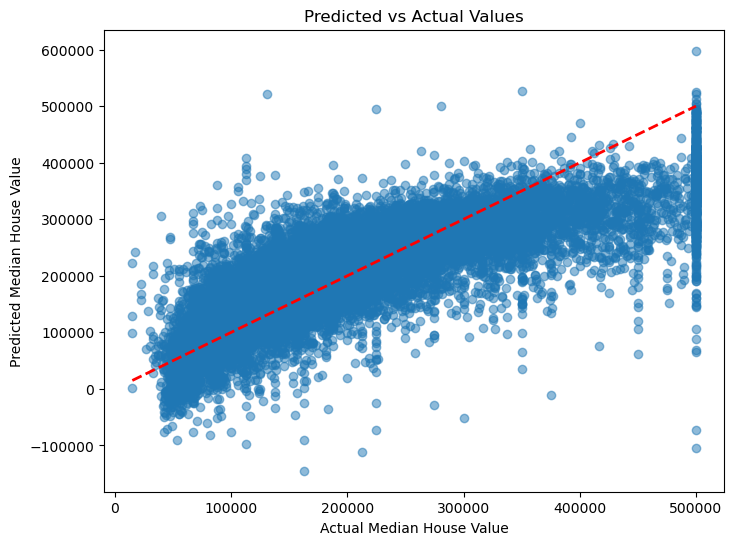

In [9]:
#Plotting Predicted vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(train_target, y_pred, alpha=0.5)
plt.plot([train_target.min(), train_target.max()],
         [train_target.min(), train_target.max()],
         'r--', lw=2)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Predicted vs Actual Values")
plt.show()

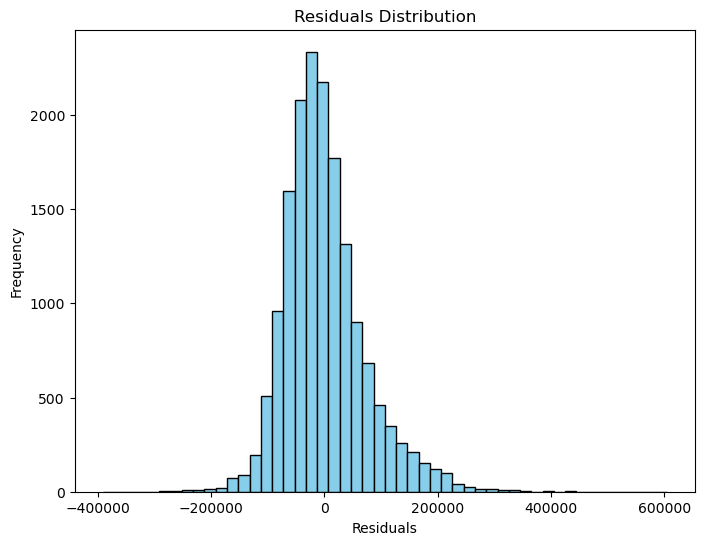

In [10]:
#Plotting Histogram of Residuals
residuals = train_target - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()